# ⏰ Cryptocurrency Price Forecasting: ARIMA, Prophet & LSTM/GRU Models

## Comprehensive Time Series Analysis with Model Comparison

This notebook implements multiple state-of-the-art time series forecasting models to predict cryptocurrency prices:

- **📊 ARIMA/SARIMA** - Statistical time series models with automatic order selection
- **🔮 Prophet** - Facebook's robust forecasting tool with seasonality handling
- **🧠 LSTM/GRU** - Deep learning sequence models for complex pattern recognition
- **📈 Model Comparison** - Comprehensive performance evaluation and visualization
- **🔮 Future Predictions** - 30-day ahead price forecasts with confidence intervals

### Key Features:
✅ **Auto Library Installation** - Automatically installs missing dependencies  
✅ **Kaggle Compatible** - Works seamlessly on Kaggle and local environments  
✅ **Multiple Models** - Compare ARIMA, Prophet, LSTM, and GRU performance  
✅ **Comprehensive Metrics** - MAE, RMSE, MAPE evaluation  
✅ **Visualizations** - Forecast plots, training history, and model comparisons  

### 📌 **Kaggle Compatible**
This notebook automatically detects if it's running on Kaggle and uses the appropriate dataset path.

---

**Keywords:** Cryptocurrency, Time Series, Forecasting, ARIMA, Prophet, LSTM, GRU, Price Prediction, Bitcoin, Ethereum, Machine Learning, Deep Learning


In [30]:
# Check and Install Required Libraries
import subprocess
import sys
import importlib

def check_and_install(package_name, import_name=None):
    """Check if a package is installed, if not, install it."""
    if import_name is None:
        import_name = package_name
    
    try:
        importlib.import_module(import_name)
        return True
    except ImportError:
        print(f"⚠️ {package_name} not found. Installing...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package_name, "--quiet"])
            print(f"✅ {package_name} installed successfully!")
            return True
        except Exception as e:
            print(f"❌ Failed to install {package_name}: {str(e)}")
            return False

# Required packages with their pip names and import names
required_packages = {
    'pandas': 'pandas',
    'numpy': 'numpy',
    'matplotlib': 'matplotlib',
    'seaborn': 'seaborn',
    'scikit-learn': 'sklearn',
    'statsmodels': 'statsmodels',
    'prophet': 'prophet',
    'tensorflow': 'tensorflow'
}

print("="*60)
print("CHECKING AND INSTALLING REQUIRED LIBRARIES")
print("="*60)

# Check and install packages
installed_packages = {}
for pip_name, import_name in required_packages.items():
    installed = check_and_install(pip_name, import_name)
    installed_packages[import_name] = installed

print("\n" + "="*60)
print("LIBRARY STATUS")
print("="*60)

# Now import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import os
from datetime import datetime, timedelta

# Time Series Libraries
try:
    from statsmodels.tsa.arima.model import ARIMA
    from statsmodels.tsa.stattools import adfuller
    from statsmodels.tsa.seasonal import seasonal_decompose
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    STATSMODELS_AVAILABLE = True
    print("✅ statsmodels - Available")
except ImportError:
    STATSMODELS_AVAILABLE = False
    print("❌ statsmodels - Not available")

# Prophet
try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
    print("✅ Prophet - Available")
except ImportError:
    PROPHET_AVAILABLE = False
    print("⚠️ Prophet - Not available (optional)")

# Deep Learning
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
    from tensorflow.keras.optimizers import Adam
    from sklearn.preprocessing import MinMaxScaler
    TENSORFLOW_AVAILABLE = True
    print("✅ TensorFlow - Available")
except ImportError:
    TENSORFLOW_AVAILABLE = False
    print("⚠️ TensorFlow - Not available (optional for LSTM/GRU)")

# Evaluation Metrics
try:
    from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
    import math
    print("✅ scikit-learn - Available")
except ImportError:
    print("❌ scikit-learn - Not available")

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Set plotting style
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

print("\n" + "="*60)
print("✅ LIBRARY CHECK COMPLETE")
print("="*60)
print(f"Prophet available: {PROPHET_AVAILABLE}")
print(f"TensorFlow available: {TENSORFLOW_AVAILABLE}")
print(f"Statsmodels available: {STATSMODELS_AVAILABLE}")

if not STATSMODELS_AVAILABLE:
    print("\n⚠️ WARNING: statsmodels is required for ARIMA models!")
    print("   Please install manually: pip install statsmodels")


CHECKING AND INSTALLING REQUIRED LIBRARIES

LIBRARY STATUS
✅ statsmodels - Available
✅ Prophet - Available
✅ TensorFlow - Available
✅ scikit-learn - Available

✅ LIBRARY CHECK COMPLETE
Prophet available: True
TensorFlow available: True
Statsmodels available: True


## 1. Data Loading and Preparation


In [31]:
# Define paths - Auto-detect Kaggle environment
if os.path.exists('/kaggle/input'):
    kaggle_base = Path('/kaggle/input/top-50-cryptocurrency-dataset')
    if kaggle_base.exists():
        csv_files_direct = list(kaggle_base.glob('*.csv'))
        if len(csv_files_direct) > 0:
            base_path = kaggle_base
            print("🔵 Running on Kaggle - CSV files found directly in dataset folder")
        else:
            dataset_subfolder = kaggle_base / 'Dataset'
            if dataset_subfolder.exists():
                base_path = dataset_subfolder
                print("🔵 Running on Kaggle - CSV files found in Dataset subfolder")
            else:
                base_path = kaggle_base
                print("🔵 Running on Kaggle - Using base dataset path")
    else:
        kaggle_input = Path('/kaggle/input')
        available_datasets = [d for d in kaggle_input.iterdir() if d.is_dir()]
        if available_datasets:
            base_path = available_datasets[0]
            print(f"🔵 Using: {base_path}")
        else:
            base_path = kaggle_base
else:
    base_path = Path('../Dataset')
    print("🟢 Running locally - Using local dataset path")

# Function to load cryptocurrency data
def load_crypto_data(file_path):
    """Load cryptocurrency CSV file and handle the header issue."""
    try:
        df = pd.read_csv(file_path, skiprows=[1])
        crypto_name = file_path.stem.replace('_', ' ').title()
        df['Date'] = pd.to_datetime(df['Date'])
        numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
        for col in numeric_cols:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        df = df.sort_values('Date').reset_index(drop=True)
        df['Cryptocurrency'] = crypto_name
        return df, crypto_name
    except Exception as e:
        print(f"Error loading {file_path.name}: {str(e)}")
        return None, None

# Load all cryptocurrency data
csv_files = list(base_path.glob('*.csv'))
if len(csv_files) == 0:
    csv_files = list(base_path.rglob('*.csv'))

crypto_data = {}
for file_path in csv_files:
    df, name = load_crypto_data(file_path)
    if df is not None and len(df) > 100:  # Only use cryptos with sufficient data
        crypto_data[name] = df

print(f"\n✅ Loaded {len(crypto_data)} cryptocurrencies with sufficient data")
print(f"Available cryptocurrencies: {sorted(list(crypto_data.keys())[:10])}...")


🟢 Running locally - Using local dataset path

✅ Loaded 49 cryptocurrencies with sufficient data
Available cryptocurrencies: ['Chainlink', 'Flow', 'Hedera', 'Immutable', 'Kaspa', 'Near', 'Render', 'Sui', 'The Graph', 'Xrp']...


In [32]:
# Select cryptocurrencies for forecasting demonstration
# We'll use top cryptocurrencies with good data coverage
selected_cryptos = ['Bitcoin', 'Ethereum', 'Solana', 'Cardano', 'Binance Coin']

# Filter to available cryptos
available_selected = [c for c in selected_cryptos if c in crypto_data]
if not available_selected:
    # Use first available cryptos if selected ones aren't available
    available_selected = list(crypto_data.keys())[:3]

print(f"Selected cryptocurrencies for forecasting: {available_selected}")

# Prepare data for forecasting
forecast_data = {}
for crypto in available_selected:
    df = crypto_data[crypto].copy()
    # Use Close price for forecasting
    df = df[['Date', 'Close']].copy()
    df = df.dropna()
    df = df.set_index('Date')
    df.columns = ['price']
    forecast_data[crypto] = df

print(f"\nData prepared for {len(forecast_data)} cryptocurrencies")
for crypto, df in forecast_data.items():
    print(f"{crypto}: {len(df)} days, from {df.index.min().date()} to {df.index.max().date()}")


Selected cryptocurrencies for forecasting: ['Bitcoin', 'Ethereum', 'Solana', 'Cardano', 'Binance Coin']

Data prepared for 5 cryptocurrencies
Bitcoin: 4129 days, from 2014-09-17 to 2026-01-05
Ethereum: 2980 days, from 2017-11-09 to 2026-01-05
Solana: 2097 days, from 2020-04-10 to 2026-01-05
Cardano: 2980 days, from 2017-11-09 to 2026-01-05
Binance Coin: 2980 days, from 2017-11-09 to 2026-01-05


## 2. Helper Functions for Model Evaluation


In [33]:
# Evaluation metrics functions
def calculate_metrics(y_true, y_pred):
    """Calculate evaluation metrics for forecasts."""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    
    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape
    }

def plot_forecast(actual, forecast, title, train_end_date=None):
    """Plot actual vs forecasted values."""
    plt.figure(figsize=(14, 6))
    plt.plot(actual.index, actual.values, label='Actual', linewidth=2, alpha=0.7)
    plt.plot(forecast.index, forecast.values, label='Forecast', linewidth=2, linestyle='--', alpha=0.8)
    if train_end_date:
        plt.axvline(x=train_end_date, color='red', linestyle=':', linewidth=1, label='Train/Test Split')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

print("✅ Helper functions defined")


✅ Helper functions defined


## 3. ARIMA Model Forecasting


In [34]:
# ARIMA Model Implementation
if STATSMODELS_AVAILABLE:
    def check_stationarity(timeseries):
        """Check if time series is stationary using Augmented Dickey-Fuller test."""
        result = adfuller(timeseries.dropna())
        return result[1] <= 0.05  # p-value <= 0.05 means stationary

    def make_stationary(series):
        """Make series stationary by differencing."""
        diff_series = series.diff().dropna()
        return diff_series

    def find_arima_order(train_data, max_p=5, max_d=2, max_q=5):
        """Find optimal ARIMA order using AIC."""
        best_aic = np.inf
        best_order = None
        
        for p in range(max_p + 1):
            for d in range(max_d + 1):
                for q in range(max_q + 1):
                    try:
                        model = ARIMA(train_data, order=(p, d, q))
                        fitted_model = model.fit()
                        if fitted_model.aic < best_aic:
                            best_aic = fitted_model.aic
                            best_order = (p, d, q)
                    except:
                        continue
        
        return best_order

    def forecast_arima(data, train_size=0.8, forecast_days=30):
        """Forecast using ARIMA model."""
        # Split data
        split_idx = int(len(data) * train_size)
        train = data[:split_idx]
        test = data[split_idx:split_idx + forecast_days] if len(data) > split_idx + forecast_days else data[split_idx:]
        
        # Check stationarity to determine d parameter
        is_stationary = check_stationarity(train)
        d_value = 0 if is_stationary else 1
        
        if not is_stationary:
            print("   Series is non-stationary, will use d=1 in ARIMA model")
        
        # Find optimal order on original data (ARIMA will handle differencing via d parameter)
        print("   Finding optimal ARIMA order...")
        # Try different orders with the determined d value
        best_aic = np.inf
        best_order = (1, d_value, 1)  # Default fallback
        
        for p in range(4):
            for q in range(4):
                try:
                    model = ARIMA(train, order=(p, d_value, q))
                    fitted = model.fit()
                    if fitted.aic < best_aic:
                        best_aic = fitted.aic
                        best_order = (p, d_value, q)
                except:
                    continue
        
        order = best_order
        print(f"   Optimal ARIMA order: {order} (AIC: {best_aic:.2f})")
        
        # Fit model on train data
        model = ARIMA(train, order=order)
        fitted_model = model.fit()
        
        # Forecast
        forecast = fitted_model.forecast(steps=len(test))
        forecast_index = test.index
        
        return train.index[-1], forecast_index, forecast, test.values, fitted_model, order
    
    print("✅ ARIMA functions defined")
else:
    print("⚠️ ARIMA functions not available - statsmodels is required")
    def forecast_arima(*args, **kwargs):
        raise ImportError("statsmodels is required for ARIMA forecasting. Please install: pip install statsmodels")


✅ ARIMA functions defined


ARIMA MODEL FORECASTING

📊 Forecasting Bitcoin...
   Series is non-stationary, will use d=1 in ARIMA model
   Finding optimal ARIMA order...
   Optimal ARIMA order: (2, 1, 3) (AIC: 53330.27)
   ✅ ARIMA(2, 1, 3)
   MAE: $2761.30
   RMSE: $3979.28
   MAPE: 8.35%


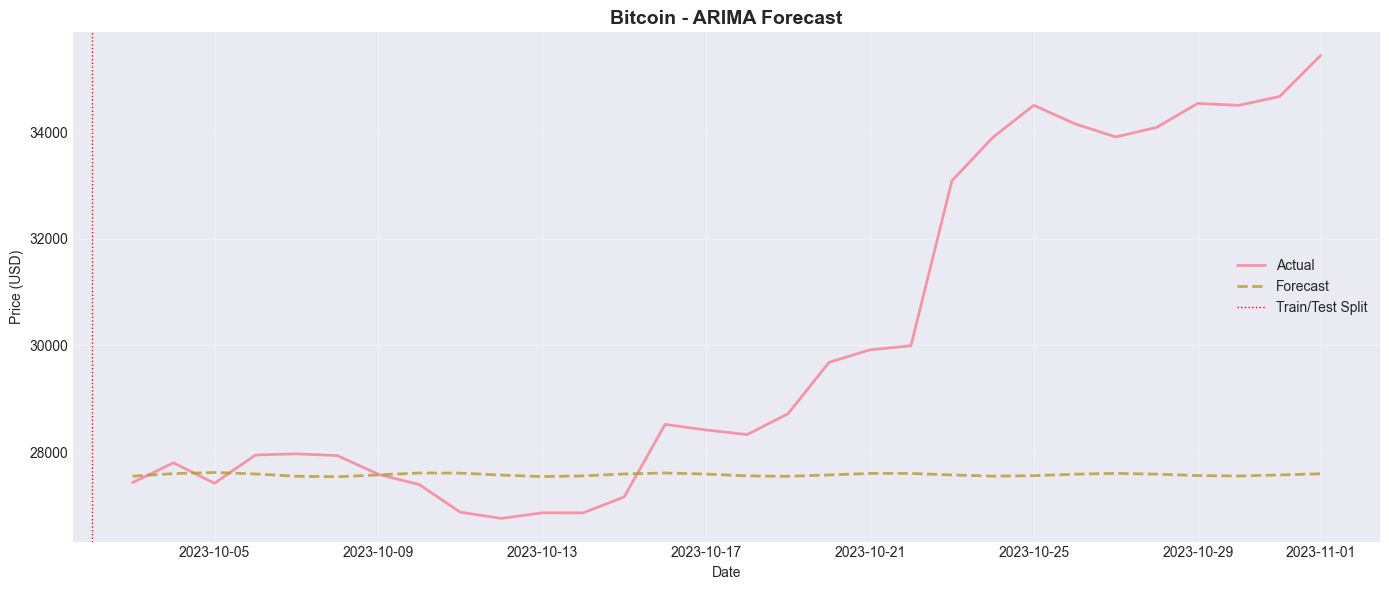


📊 Forecasting Ethereum...
   Series is non-stationary, will use d=1 in ARIMA model
   Finding optimal ARIMA order...
   Optimal ARIMA order: (2, 1, 3) (AIC: 27389.17)
   ✅ ARIMA(2, 1, 3)
   MAE: $620.62
   RMSE: $632.37
   MAPE: 16.68%


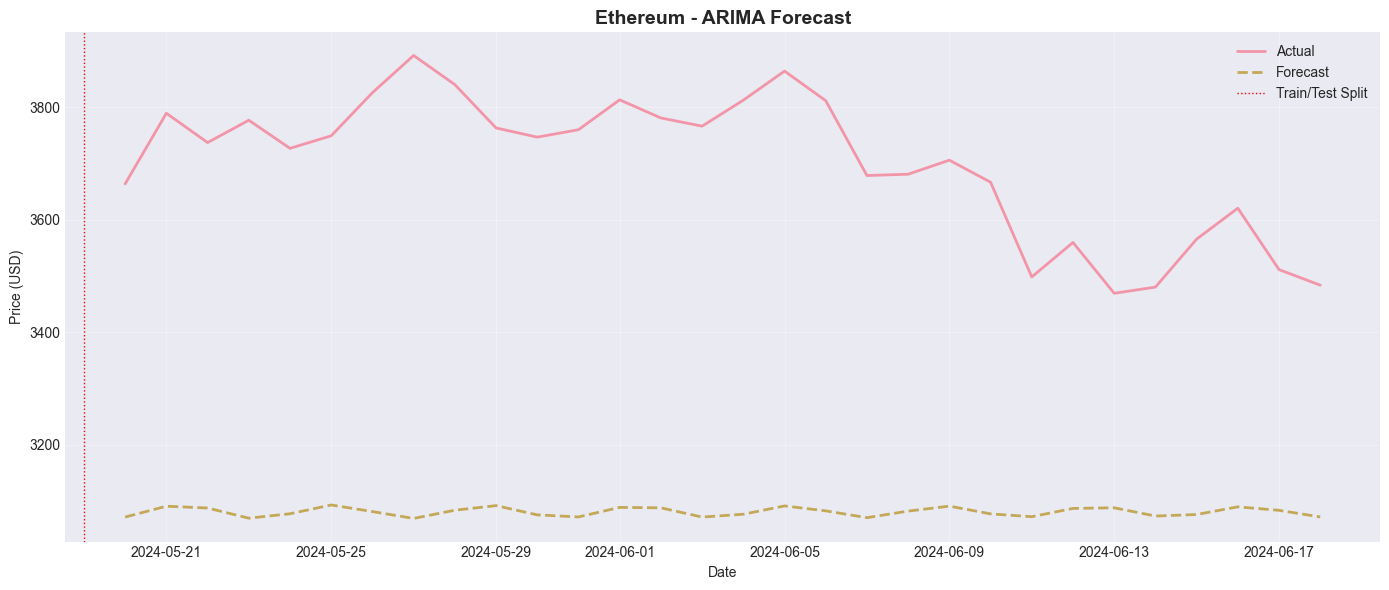


📊 Forecasting Solana...
   Series is non-stationary, will use d=1 in ARIMA model
   Finding optimal ARIMA order...
   Optimal ARIMA order: (2, 1, 3) (AIC: 9894.32)
   ✅ ARIMA(2, 1, 3)
   MAE: $14.22
   RMSE: $16.38
   MAPE: 5.96%


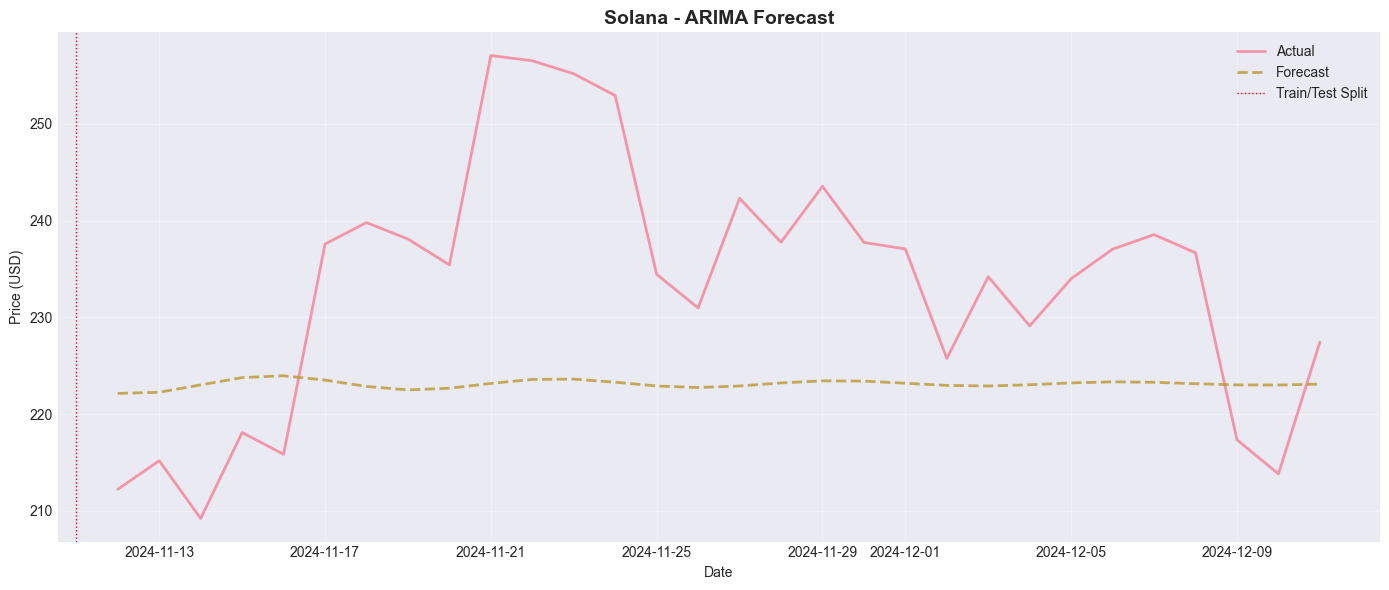


✅ ARIMA forecasting completed for 3 cryptocurrencies


In [35]:
# Run ARIMA forecasting for selected cryptocurrencies
arima_results = {}

if STATSMODELS_AVAILABLE:
    print("="*60)
    print("ARIMA MODEL FORECASTING")
    print("="*60)

    for crypto in available_selected[:3]:  # Limit to 3 for demonstration
        print(f"\n📊 Forecasting {crypto}...")
        data = forecast_data[crypto]['price']
        
        try:
            train_end, forecast_idx, forecast, actual, model, order = forecast_arima(
                data, train_size=0.8, forecast_days=30
            )
            
            # Calculate metrics
            metrics = calculate_metrics(actual, forecast)
            arima_results[crypto] = {
                'forecast': pd.Series(forecast, index=forecast_idx),
                'actual': pd.Series(actual, index=forecast_idx),
                'metrics': metrics,
                'model': model,
                'order': order,
                'train_end': train_end
            }
            
            print(f"   ✅ ARIMA{order}")
            print(f"   MAE: ${metrics['MAE']:.2f}")
            print(f"   RMSE: ${metrics['RMSE']:.2f}")
            print(f"   MAPE: {metrics['MAPE']:.2f}%")
            
            # Plot results
            plot_forecast(
                pd.Series(actual, index=forecast_idx),
                pd.Series(forecast, index=forecast_idx),
                f'{crypto} - ARIMA Forecast',
                train_end_date=train_end
            )
            
        except Exception as e:
            print(f"   ❌ Error forecasting {crypto}: {str(e)}")
            continue

    print(f"\n✅ ARIMA forecasting completed for {len(arima_results)} cryptocurrencies")
else:
    print("="*60)
    print("ARIMA MODEL FORECASTING")
    print("="*60)
    print("⚠️ ARIMA forecasting skipped - statsmodels is not available")
    print("   Please install: pip install statsmodels")


## 4. Prophet Model Forecasting


In [36]:
# Prophet Model Implementation
def forecast_prophet(data, train_size=0.8, forecast_days=30):
    """Forecast using Facebook Prophet model."""
    if not PROPHET_AVAILABLE:
        print("Prophet not available. Skipping...")
        return None
    
    # Split data
    split_idx = int(len(data) * train_size)
    train = data[:split_idx]
    test = data[split_idx:split_idx + forecast_days] if len(data) > split_idx + forecast_days else data[split_idx:]
    
    # Prepare data for Prophet (requires 'ds' and 'y' columns)
    train_df = pd.DataFrame({
        'ds': train.index,
        'y': train.values
    })
    
    # Initialize and fit Prophet model
    model = Prophet(
        daily_seasonality=False,
        weekly_seasonality=True,
        yearly_seasonality=True,
        changepoint_prior_scale=0.05  # Regularization
    )
    model.fit(train_df)
    
    # Create future dataframe
    future = model.make_future_dataframe(periods=len(test))
    
    # Forecast
    forecast_df = model.predict(future)
    
    # Extract forecast for test period
    forecast_values = forecast_df.tail(len(test))['yhat'].values
    forecast_index = test.index
    
    return train.index[-1], forecast_index, forecast_values, test.values, model, forecast_df

print("✅ Prophet functions defined")


✅ Prophet functions defined


PROPHET MODEL FORECASTING

📊 Forecasting Bitcoin with Prophet...


13:41:00 - cmdstanpy - INFO - Chain [1] start processing
13:41:00 - cmdstanpy - INFO - Chain [1] done processing


   ✅ Prophet model fitted
   MAE: $12986.89
   RMSE: $13276.82
   MAPE: 42.71%


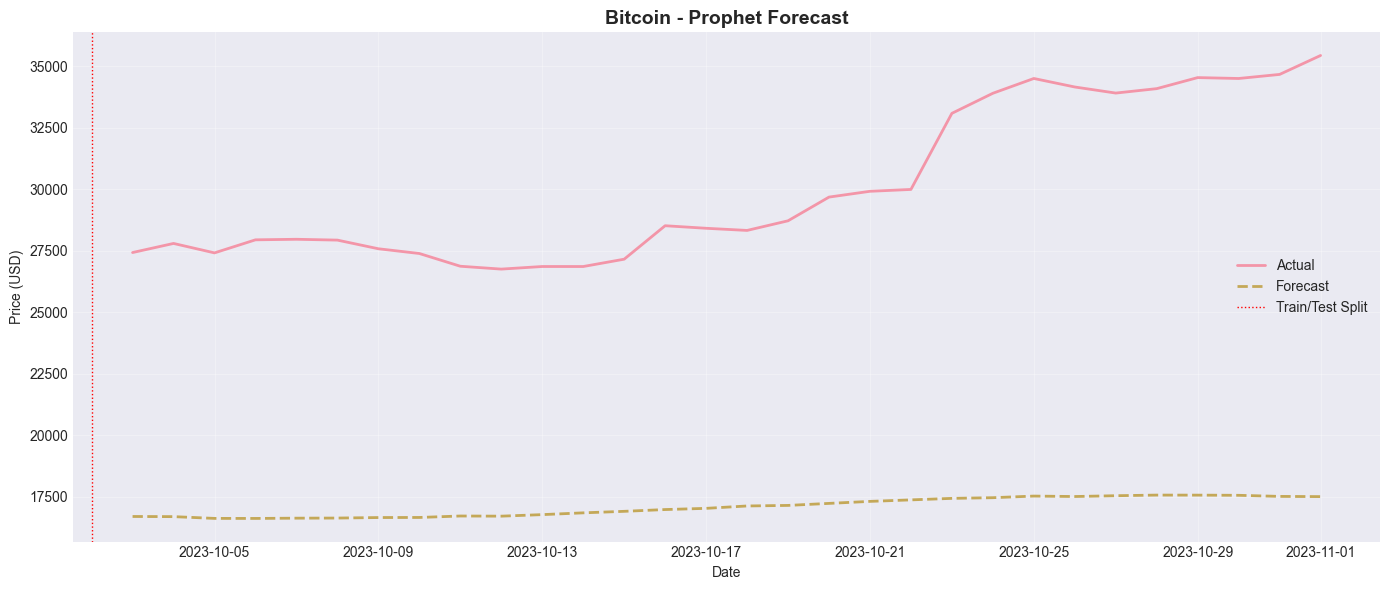

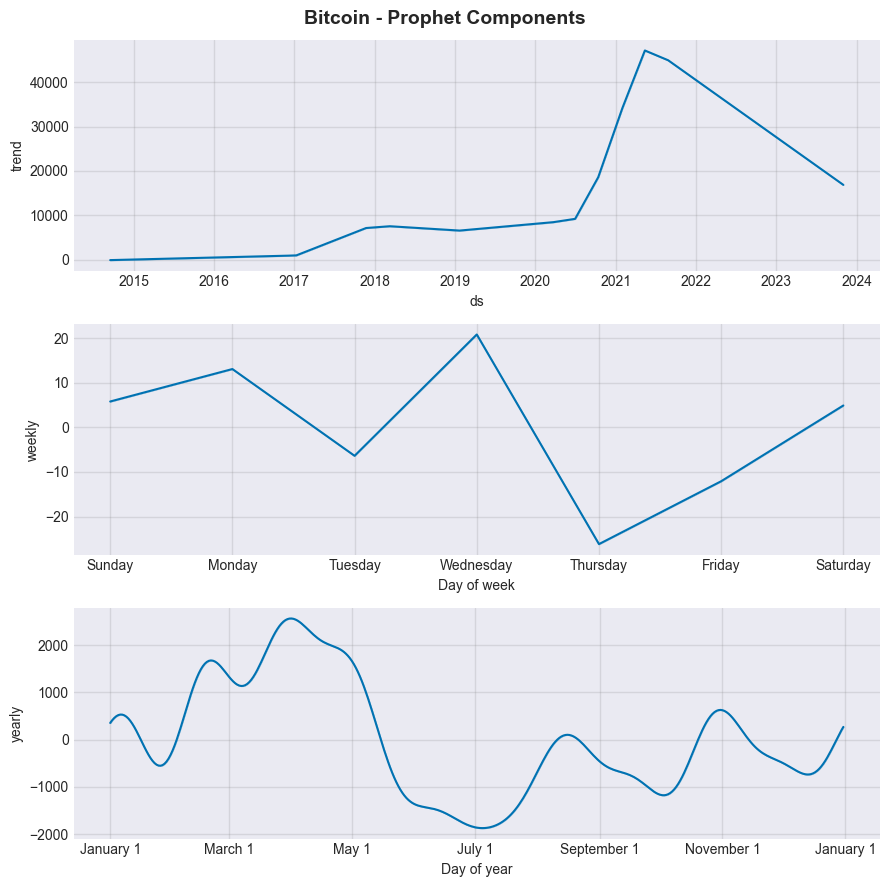

13:41:01 - cmdstanpy - INFO - Chain [1] start processing



📊 Forecasting Ethereum with Prophet...


13:41:01 - cmdstanpy - INFO - Chain [1] done processing


   ✅ Prophet model fitted
   MAE: $705.38
   RMSE: $711.68
   MAPE: 19.00%


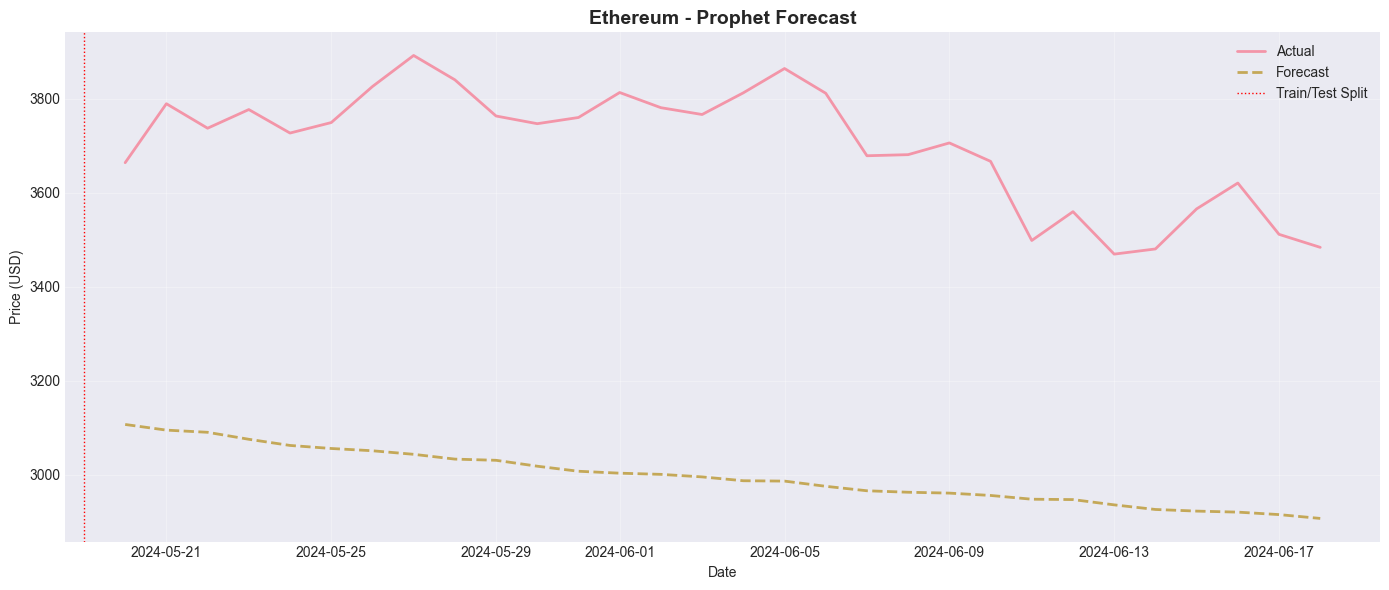

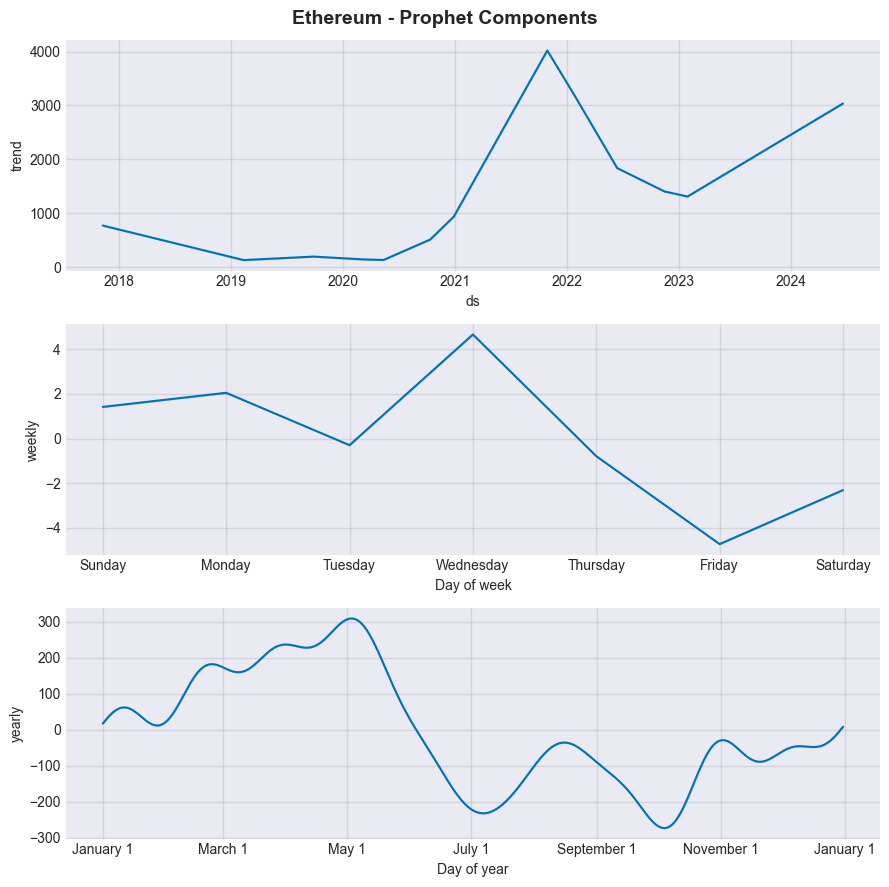

13:41:02 - cmdstanpy - INFO - Chain [1] start processing



📊 Forecasting Solana with Prophet...


13:41:02 - cmdstanpy - INFO - Chain [1] done processing


   ✅ Prophet model fitted
   MAE: $37.18
   RMSE: $39.55
   MAPE: 15.66%


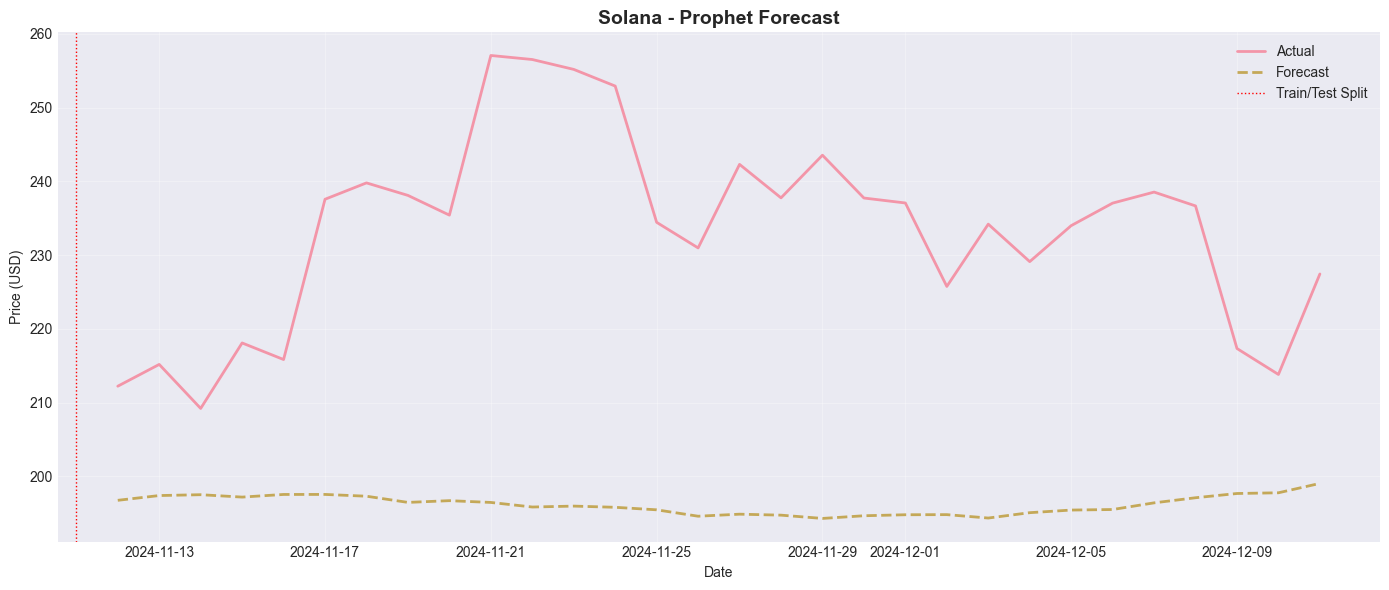

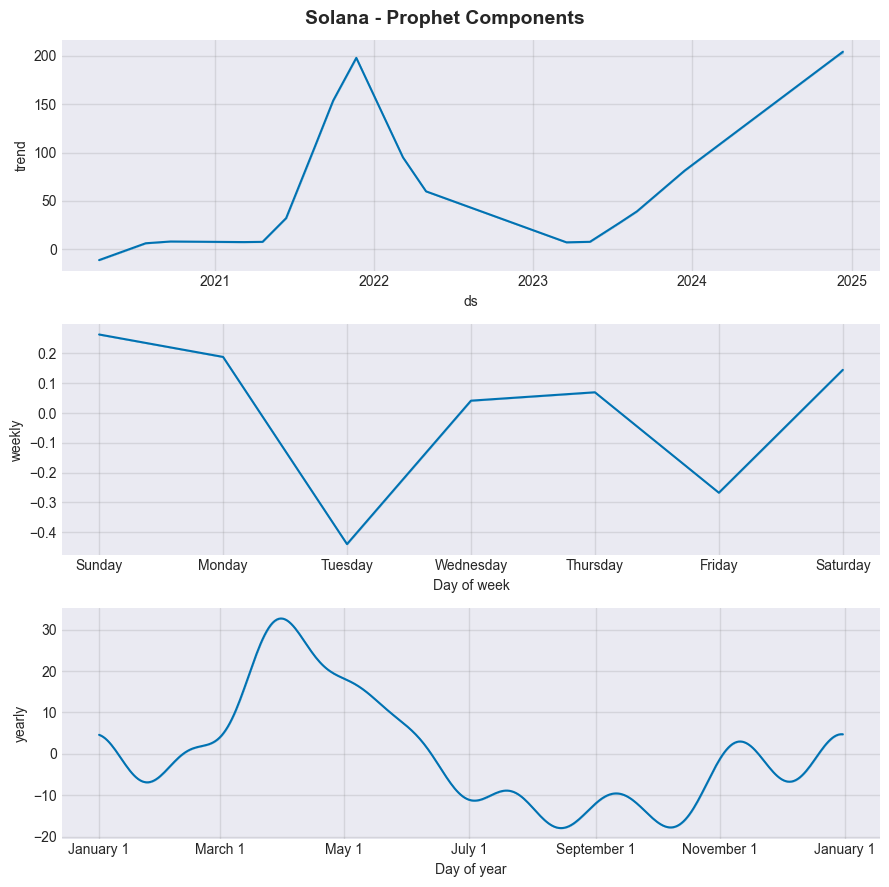


✅ Prophet forecasting completed for 3 cryptocurrencies


In [37]:
# Run Prophet forecasting
prophet_results = {}

if PROPHET_AVAILABLE:
    print("="*60)
    print("PROPHET MODEL FORECASTING")
    print("="*60)
    
    for crypto in available_selected[:3]:  # Limit to 3 for demonstration
        print(f"\n📊 Forecasting {crypto} with Prophet...")
        data = forecast_data[crypto]['price']
        
        try:
            train_end, forecast_idx, forecast, actual, model, forecast_df = forecast_prophet(
                data, train_size=0.8, forecast_days=30
            )
            
            # Calculate metrics
            metrics = calculate_metrics(actual, forecast)
            prophet_results[crypto] = {
                'forecast': pd.Series(forecast, index=forecast_idx),
                'actual': pd.Series(actual, index=forecast_idx),
                'metrics': metrics,
                'model': model,
                'forecast_df': forecast_df,
                'train_end': train_end
            }
            
            print(f"   ✅ Prophet model fitted")
            print(f"   MAE: ${metrics['MAE']:.2f}")
            print(f"   RMSE: ${metrics['RMSE']:.2f}")
            print(f"   MAPE: {metrics['MAPE']:.2f}%")
            
            # Plot results
            plot_forecast(
                pd.Series(actual, index=forecast_idx),
                pd.Series(forecast, index=forecast_idx),
                f'{crypto} - Prophet Forecast',
                train_end_date=train_end
            )
            
            # Plot Prophet components
            try:
                fig = model.plot_components(forecast_df)
                plt.suptitle(f'{crypto} - Prophet Components', fontsize=14, fontweight='bold')
                plt.tight_layout()
                plt.show()
            except:
                pass
            
        except Exception as e:
            print(f"   ❌ Error forecasting {crypto}: {str(e)}")
            continue
    
    print(f"\n✅ Prophet forecasting completed for {len(prophet_results)} cryptocurrencies")
else:
    print("⚠️ Prophet not available. Install with: pip install prophet")


## 5. LSTM/GRU Deep Learning Models


In [38]:
# LSTM/GRU Model Implementation
def create_sequences(data, seq_length=60):
    """Create sequences for LSTM/GRU training."""
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

def build_lstm_model(seq_length, units=50, dropout=0.2):
    """Build LSTM model."""
    model = Sequential([
        LSTM(units, return_sequences=True, input_shape=(seq_length, 1)),
        Dropout(dropout),
        LSTM(units, return_sequences=False),
        Dropout(dropout),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

def build_gru_model(seq_length, units=50, dropout=0.2):
    """Build GRU model."""
    model = Sequential([
        GRU(units, return_sequences=True, input_shape=(seq_length, 1)),
        Dropout(dropout),
        GRU(units, return_sequences=False),
        Dropout(dropout),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

def forecast_lstm_gru(data, train_size=0.8, forecast_days=30, seq_length=60, model_type='lstm'):
    """Forecast using LSTM or GRU model."""
    if not TENSORFLOW_AVAILABLE:
        print("TensorFlow not available. Skipping...")
        return None
    
    # Split data
    split_idx = int(len(data) * train_size)
    train = data[:split_idx]
    # For LSTM/GRU, we need more test data to create sequences, so use more if available
    test_size_needed = max(forecast_days, seq_length + 10)
    test = data[split_idx:split_idx + test_size_needed] if len(data) > split_idx + test_size_needed else data[split_idx:]
    
    # Check if we have enough data
    if len(train) < seq_length + 10:
        raise ValueError(f"Not enough training data. Need at least {seq_length + 10} points, got {len(train)}")
    if len(test) < seq_length + 1:
        # If test is too short, we can't create proper sequences
        # In this case, we'll use a rolling forecast approach
        print(f"   Warning: Test data is short ({len(test)} points). Using rolling forecast approach.")
        # Use all available test data
        pass
    
    # Scale data - use full dataset for scaling to avoid data leakage
    scaler = MinMaxScaler()
    full_data_scaled = scaler.fit_transform(data.values.reshape(-1, 1)).flatten()
    
    # Split scaled data
    train_scaled = full_data_scaled[:split_idx]
    test_scaled = full_data_scaled[split_idx:split_idx + len(test)]
    
    # Create sequences from training data
    X_train, y_train = create_sequences(train_scaled, seq_length)
    
    if len(X_train) == 0:
        raise ValueError(f"Cannot create training sequences. Need at least {seq_length + 1} training points.")
    
    # For test, create sequences using the last seq_length points from train + test data
    # This ensures continuity
    test_sequences = []
    test_targets = []
    
    # Combine last part of train with test for creating sequences
    combined_for_test = np.concatenate([train_scaled[-seq_length:], test_scaled])
    
    # Create sequences - we can predict up to len(test_scaled) points
    max_predictions = min(len(test_scaled), forecast_days)
    for i in range(max_predictions):
        if i + seq_length < len(combined_for_test):
            test_sequences.append(combined_for_test[i:i+seq_length])
            test_targets.append(combined_for_test[i+seq_length])
    
    if len(test_sequences) == 0:
        raise ValueError("Cannot create test sequences. Test data too short.")
    
    X_test = np.array(test_sequences)
    y_test = np.array(test_targets)
    
    # Reshape for LSTM/GRU
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    # Build and train model
    if model_type.lower() == 'lstm':
        model = build_lstm_model(seq_length)
    else:
        model = build_gru_model(seq_length)
    
    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.1,
        verbose=0,
        shuffle=False
    )
    
    # Predict
    predictions_scaled = model.predict(X_test, verbose=0)
    
    # Inverse transform
    predictions = scaler.inverse_transform(predictions_scaled).flatten()
    actual = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    
    # Align indices - predictions correspond to test targets
    # Limit to forecast_days if we have more predictions
    num_predictions = min(len(predictions), forecast_days)
    predictions = predictions[:num_predictions]
    actual = actual[:num_predictions]
    forecast_index = test.index[:num_predictions]
    
    return train.index[-1], forecast_index, predictions, actual, model, history

print("✅ LSTM/GRU functions defined")


✅ LSTM/GRU functions defined


LSTM MODEL FORECASTING

📊 Forecasting Bitcoin with LSTM...
   ✅ LSTM model trained
   MAE: $911.27
   RMSE: $1266.75
   MAPE: 2.88%


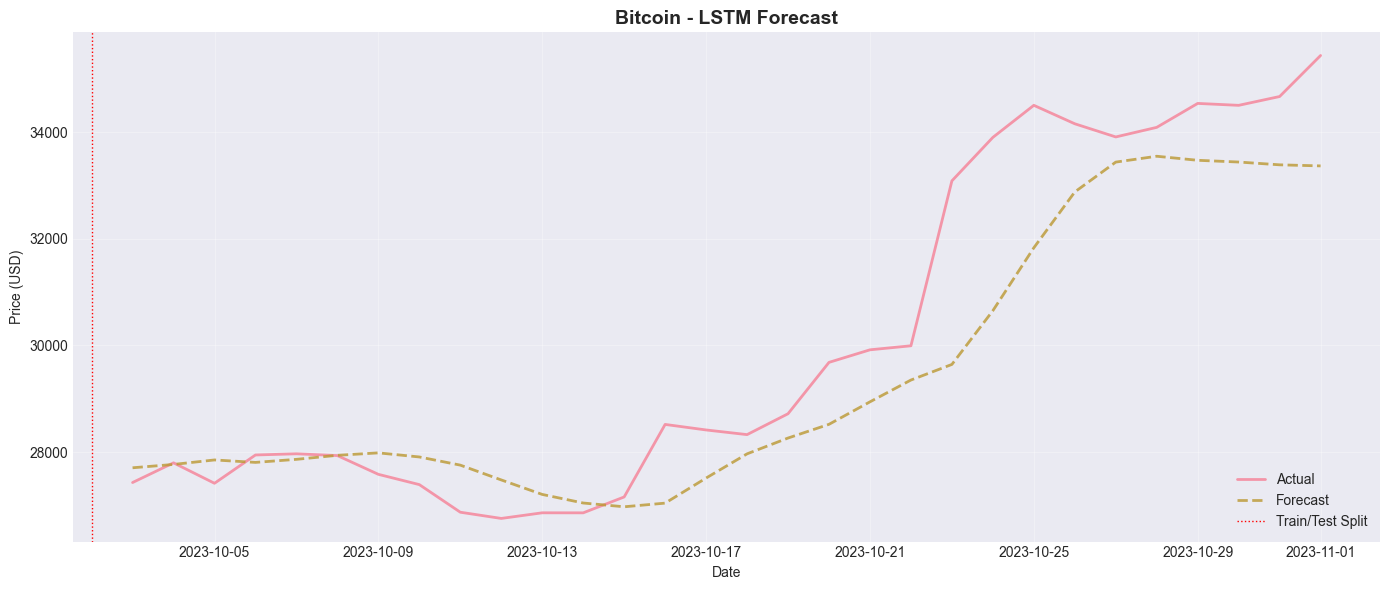

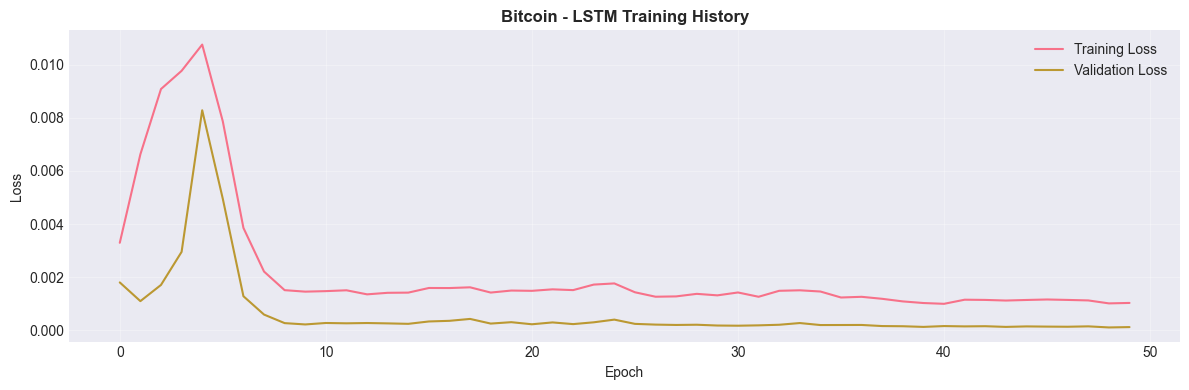


📊 Forecasting Ethereum with LSTM...
   ✅ LSTM model trained
   MAE: $663.46
   RMSE: $673.71
   MAPE: 17.90%


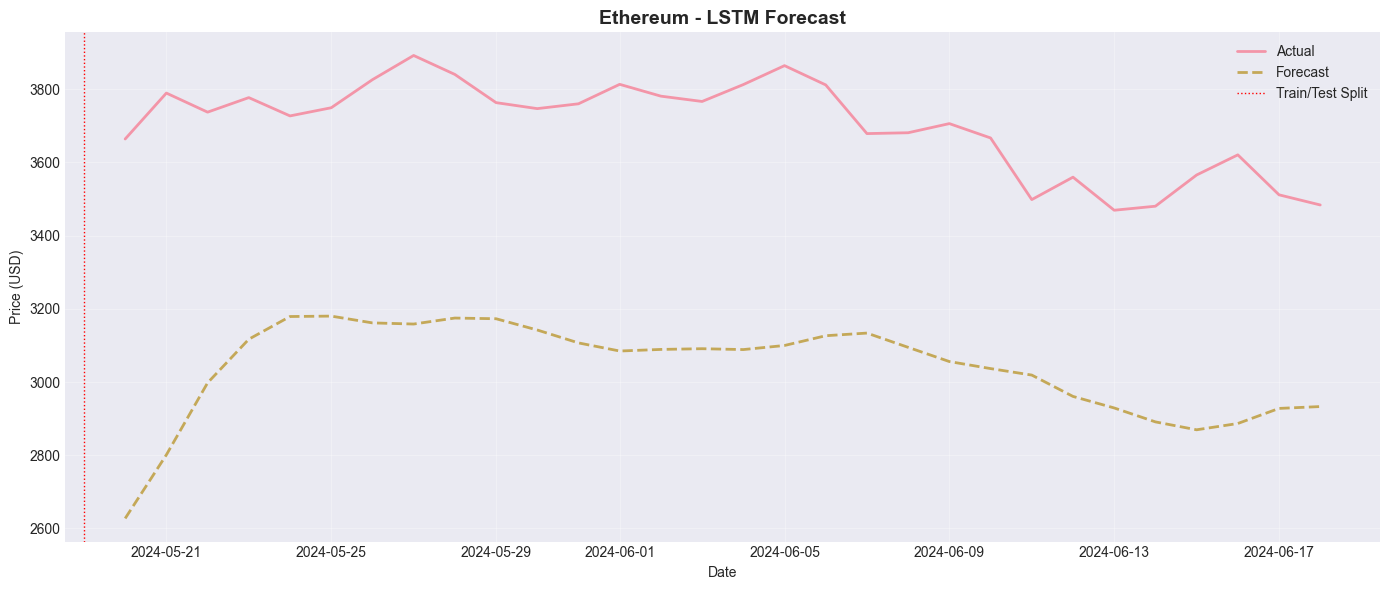

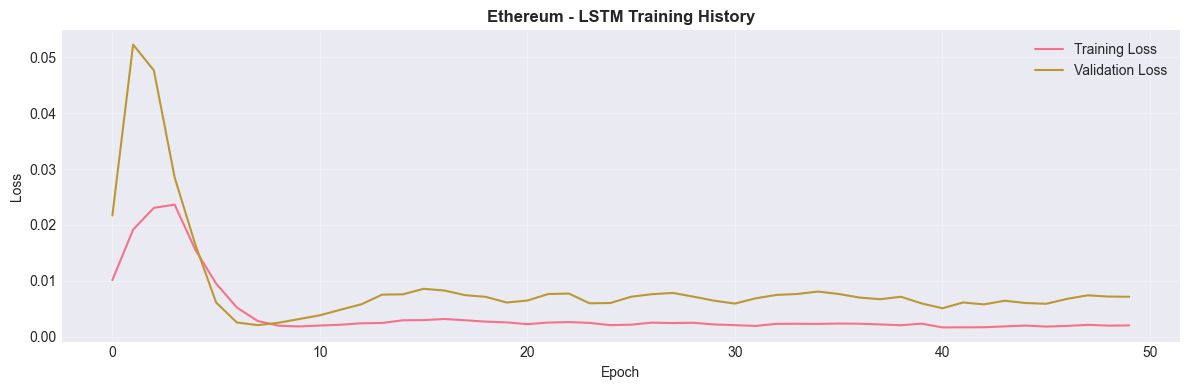


✅ LSTM forecasting completed for 2 cryptocurrencies


In [39]:
# Run LSTM forecasting
lstm_results = {}

if TENSORFLOW_AVAILABLE:
    print("="*60)
    print("LSTM MODEL FORECASTING")
    print("="*60)
    
    for crypto in available_selected[:2]:  # Limit to 2 for demonstration (LSTM is slower)
        print(f"\n📊 Forecasting {crypto} with LSTM...")
        data = forecast_data[crypto]['price']
        
        # Check if we have enough data for LSTM
        if len(data) < 200:  # Need sufficient data for LSTM
            print(f"   ⚠️ Skipping {crypto}: Insufficient data ({len(data)} points). Need at least 200 points.")
            continue
        
        try:
            train_end, forecast_idx, forecast, actual, model, history = forecast_lstm_gru(
                data, train_size=0.8, forecast_days=30, seq_length=60, model_type='lstm'
            )
            
            # Calculate metrics
            metrics = calculate_metrics(actual, forecast)
            lstm_results[crypto] = {
                'forecast': pd.Series(forecast, index=forecast_idx),
                'actual': pd.Series(actual, index=forecast_idx),
                'metrics': metrics,
                'model': model,
                'history': history,
                'train_end': train_end
            }
            
            print(f"   ✅ LSTM model trained")
            print(f"   MAE: ${metrics['MAE']:.2f}")
            print(f"   RMSE: ${metrics['RMSE']:.2f}")
            print(f"   MAPE: {metrics['MAPE']:.2f}%")
            
            # Plot results
            plot_forecast(
                pd.Series(actual, index=forecast_idx),
                pd.Series(forecast, index=forecast_idx),
                f'{crypto} - LSTM Forecast',
                train_end_date=train_end
            )
            
            # Plot training history
            plt.figure(figsize=(12, 4))
            plt.plot(history.history['loss'], label='Training Loss')
            plt.plot(history.history['val_loss'], label='Validation Loss')
            plt.title(f'{crypto} - LSTM Training History', fontsize=12, fontweight='bold')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"   ❌ Error forecasting {crypto}: {str(e)}")
            continue
    
    print(f"\n✅ LSTM forecasting completed for {len(lstm_results)} cryptocurrencies")
else:
    print("⚠️ TensorFlow not available. Install with: pip install tensorflow")


GRU MODEL FORECASTING

📊 Forecasting Bitcoin with GRU...
   ✅ GRU model trained
   MAE: $1367.55
   RMSE: $1752.59
   MAPE: 4.27%


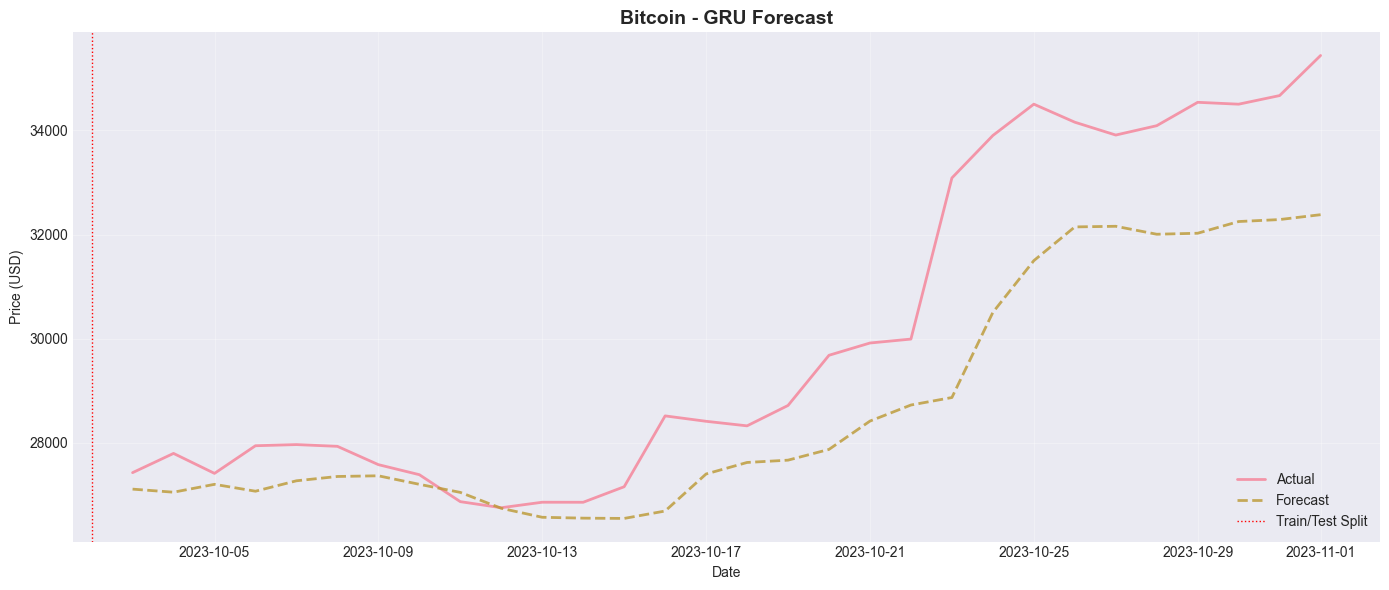

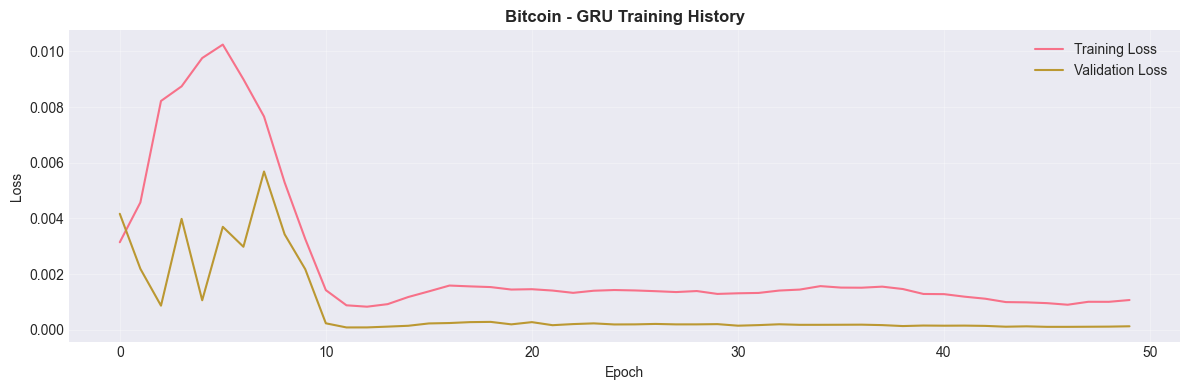


📊 Forecasting Ethereum with GRU...
   ✅ GRU model trained
   MAE: $846.26
   RMSE: $851.64
   MAPE: 22.84%


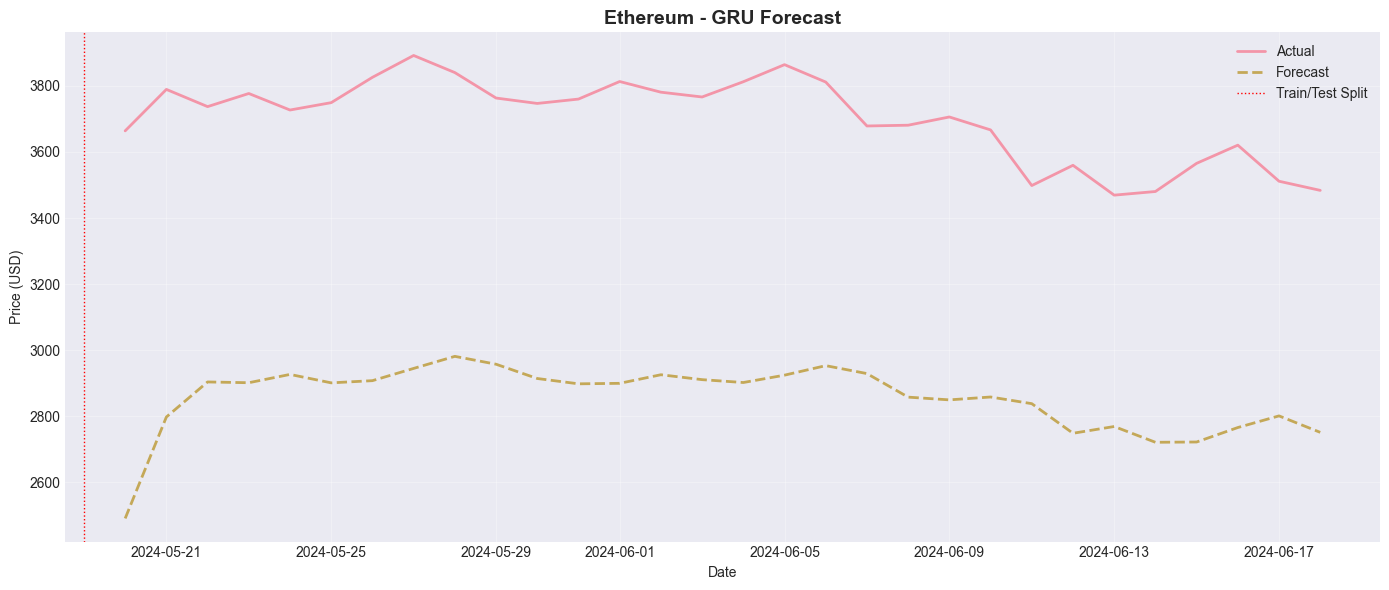

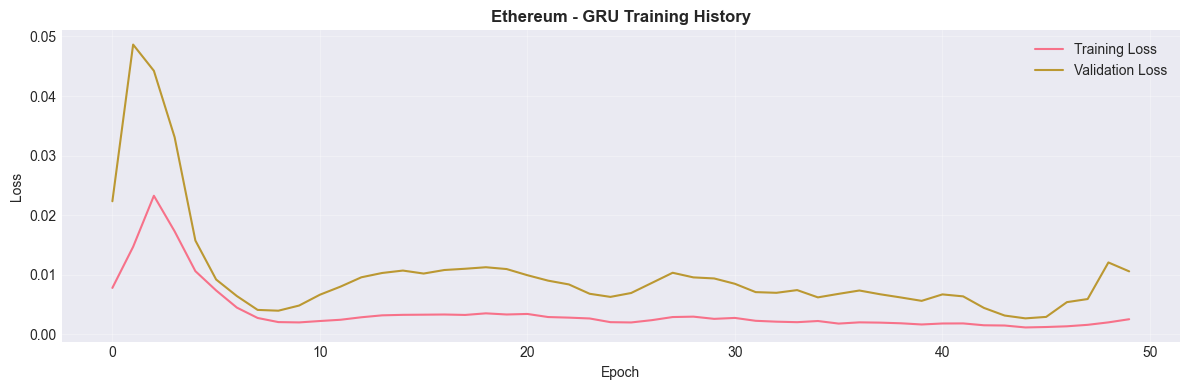


✅ GRU forecasting completed for 2 cryptocurrencies


In [40]:
# Run GRU forecasting
gru_results = {}

if TENSORFLOW_AVAILABLE:
    print("="*60)
    print("GRU MODEL FORECASTING")
    print("="*60)
    
    for crypto in available_selected[:2]:  # Limit to 2 for demonstration
        print(f"\n📊 Forecasting {crypto} with GRU...")
        data = forecast_data[crypto]['price']
        
        # Check if we have enough data for GRU
        if len(data) < 200:  # Need sufficient data for GRU
            print(f"   ⚠️ Skipping {crypto}: Insufficient data ({len(data)} points). Need at least 200 points.")
            continue
        
        try:
            train_end, forecast_idx, forecast, actual, model, history = forecast_lstm_gru(
                data, train_size=0.8, forecast_days=30, seq_length=60, model_type='gru'
            )
            
            # Calculate metrics
            metrics = calculate_metrics(actual, forecast)
            gru_results[crypto] = {
                'forecast': pd.Series(forecast, index=forecast_idx),
                'actual': pd.Series(actual, index=forecast_idx),
                'metrics': metrics,
                'model': model,
                'history': history,
                'train_end': train_end
            }
            
            print(f"   ✅ GRU model trained")
            print(f"   MAE: ${metrics['MAE']:.2f}")
            print(f"   RMSE: ${metrics['RMSE']:.2f}")
            print(f"   MAPE: {metrics['MAPE']:.2f}%")
            
            # Plot results
            plot_forecast(
                pd.Series(actual, index=forecast_idx),
                pd.Series(forecast, index=forecast_idx),
                f'{crypto} - GRU Forecast',
                train_end_date=train_end
            )
            
            # Plot training history
            plt.figure(figsize=(12, 4))
            plt.plot(history.history['loss'], label='Training Loss')
            plt.plot(history.history['val_loss'], label='Validation Loss')
            plt.title(f'{crypto} - GRU Training History', fontsize=12, fontweight='bold')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"   ❌ Error forecasting {crypto}: {str(e)}")
            continue
    
    print(f"\n✅ GRU forecasting completed for {len(gru_results)} cryptocurrencies")
else:
    print("⚠️ TensorFlow not available. Install with: pip install tensorflow")


## 6. Model Comparison and Evaluation


MODEL COMPARISON SUMMARY

📊 Model Performance Comparison:
Cryptocurrency   Model        MAE       RMSE    MAPE
       Bitcoin    LSTM   911.2674  1266.7471  2.8753
       Bitcoin     GRU  1367.5533  1752.5929  4.2735
       Bitcoin   ARIMA  2761.3031  3979.2804  8.3513
       Bitcoin Prophet 12986.8937 13276.8233 42.7127
      Ethereum   ARIMA   620.6197   632.3736 16.6755
      Ethereum    LSTM   663.4648   673.7133 17.9002
      Ethereum Prophet   705.3801   711.6823 19.0019
      Ethereum     GRU   846.2622   851.6437 22.8359
        Solana   ARIMA    14.2197    16.3832  5.9580
        Solana Prophet    37.1842    39.5499 15.6610


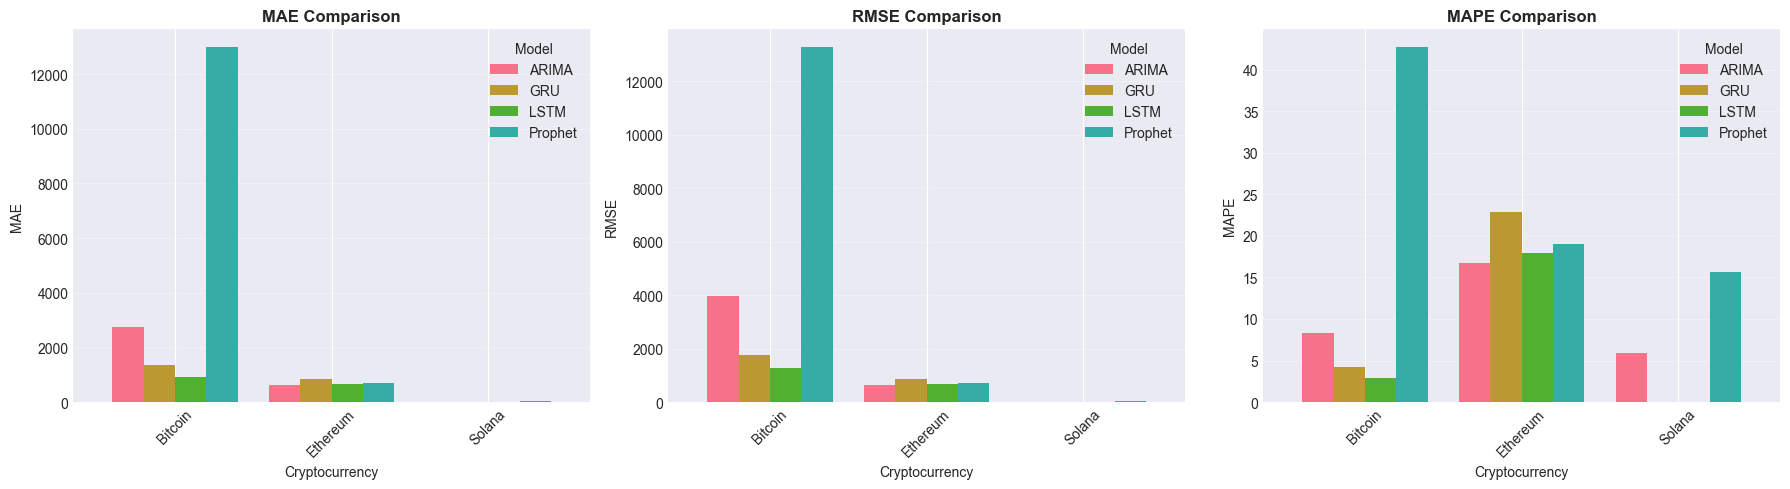


🏆 Best Model for Each Cryptocurrency (by RMSE):
Cryptocurrency Model      RMSE    MAPE
       Bitcoin  LSTM 1266.7471  2.8753
      Ethereum ARIMA  632.3736 16.6755
        Solana ARIMA   16.3832  5.9580


In [41]:
# Compare all models
print("="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)

comparison_results = []

# Collect results from all models
all_results = {
    'ARIMA': arima_results,
    'Prophet': prophet_results if PROPHET_AVAILABLE else {},
    'LSTM': lstm_results if TENSORFLOW_AVAILABLE else {},
    'GRU': gru_results if TENSORFLOW_AVAILABLE else {}
}

# Create comparison dataframe
for model_name, results in all_results.items():
    for crypto, result in results.items():
        metrics = result['metrics']
        comparison_results.append({
            'Cryptocurrency': crypto,
            'Model': model_name,
            'MAE': metrics['MAE'],
            'RMSE': metrics['RMSE'],
            'MAPE': metrics['MAPE']
        })

if comparison_results:
    comparison_df = pd.DataFrame(comparison_results)
    comparison_df = comparison_df.sort_values(['Cryptocurrency', 'RMSE'])
    
    print("\n📊 Model Performance Comparison:")
    print(comparison_df.to_string(index=False))
    
    # Visualize comparison
    if len(comparison_df) > 0:
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        metrics_to_plot = ['MAE', 'RMSE', 'MAPE']
        for idx, metric in enumerate(metrics_to_plot):
            pivot_df = comparison_df.pivot(index='Cryptocurrency', columns='Model', values=metric)
            pivot_df.plot(kind='bar', ax=axes[idx], width=0.8)
            axes[idx].set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
            axes[idx].set_xlabel('Cryptocurrency')
            axes[idx].set_ylabel(metric)
            axes[idx].legend(title='Model')
            axes[idx].grid(True, alpha=0.3, axis='y')
            axes[idx].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # Find best model for each cryptocurrency
        print("\n🏆 Best Model for Each Cryptocurrency (by RMSE):")
        best_models = comparison_df.loc[comparison_df.groupby('Cryptocurrency')['RMSE'].idxmin()]
        print(best_models[['Cryptocurrency', 'Model', 'RMSE', 'MAPE']].to_string(index=False))
else:
    print("No results available for comparison.")


## 7. Future Price Predictions


FUTURE PRICE PREDICTIONS (Next 30 Days)

📈 Bitcoin - Future Predictions:


13:46:38 - cmdstanpy - INFO - Chain [1] start processing
13:46:39 - cmdstanpy - INFO - Chain [1] done processing


   Current Price: $94033.12
   Predicted Price (30 days): $123195.28
   Confidence Interval: $115279.92 - $131204.28


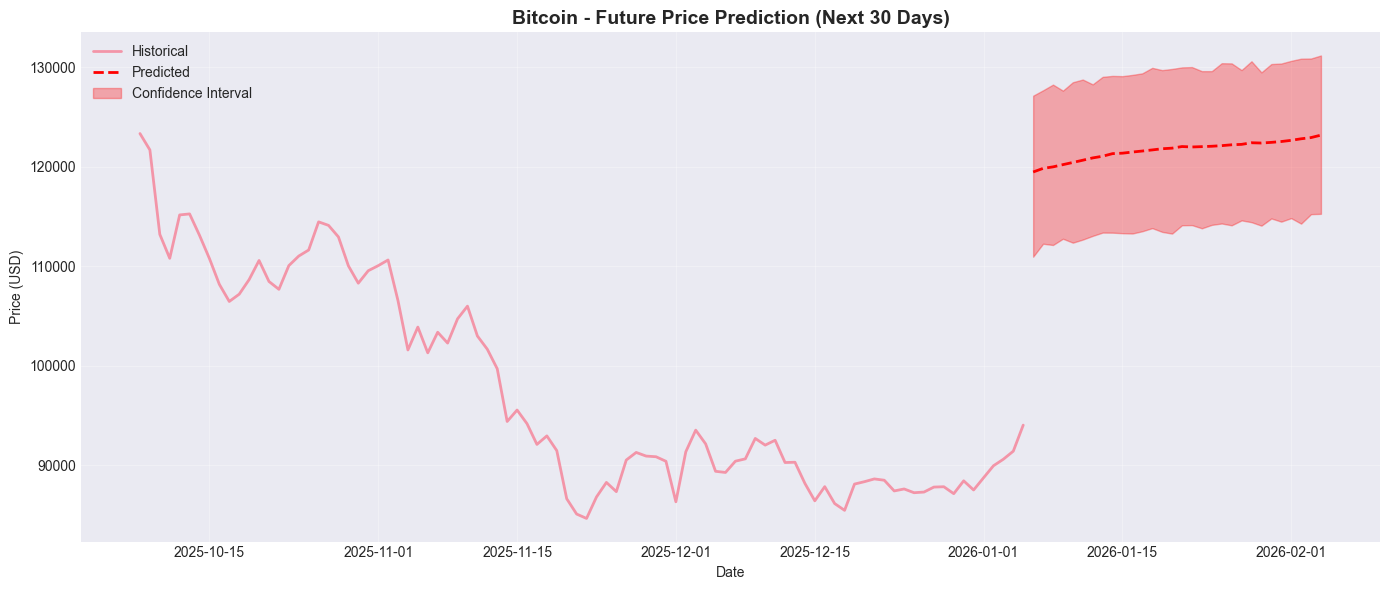

13:46:39 - cmdstanpy - INFO - Chain [1] start processing



📈 Ethereum - Future Predictions:


13:46:40 - cmdstanpy - INFO - Chain [1] done processing


   Current Price: $3202.15
   Predicted Price (30 days): $3311.56
   Confidence Interval: $2767.35 - $3889.47


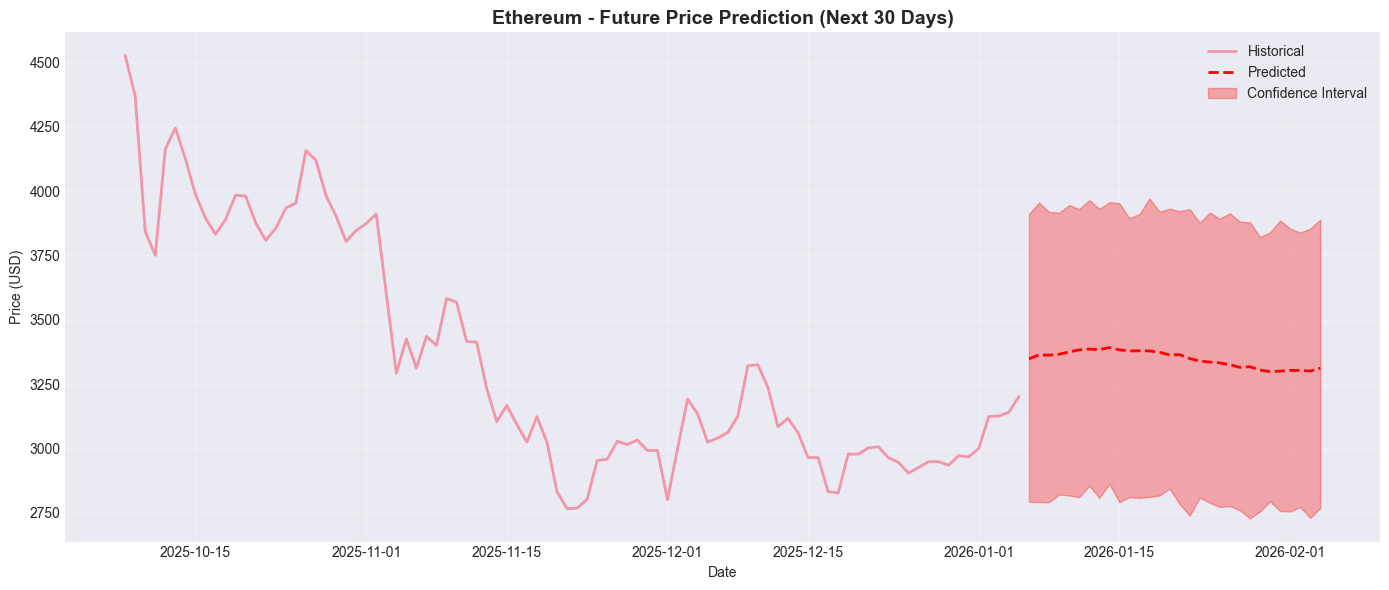

13:46:40 - cmdstanpy - INFO - Chain [1] start processing



📈 Solana - Future Predictions:


13:46:40 - cmdstanpy - INFO - Chain [1] done processing


   Current Price: $136.23
   Predicted Price (30 days): $163.83
   Confidence Interval: $130.19 - $193.65


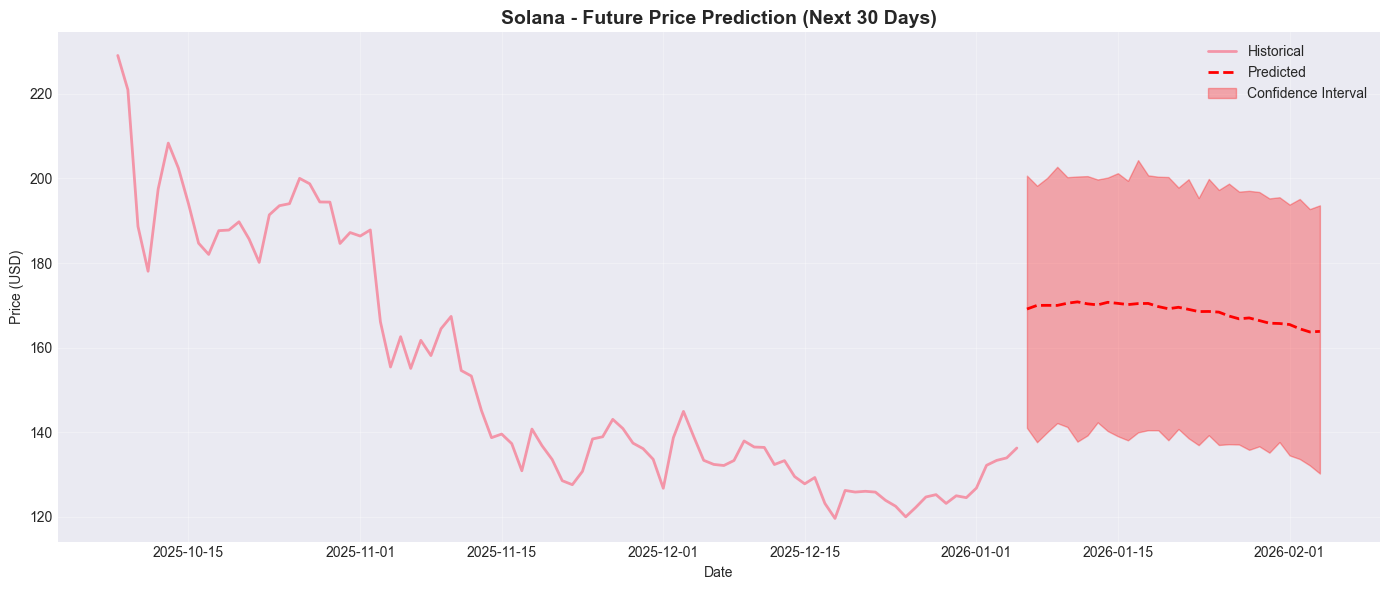


✅ Future predictions generated for 3 cryptocurrencies


In [42]:
# Generate future predictions using best model for each crypto
print("="*60)
print("FUTURE PRICE PREDICTIONS (Next 30 Days)")
print("="*60)

future_predictions = {}

for crypto in available_selected[:3]:
    print(f"\n📈 {crypto} - Future Predictions:")
    data = forecast_data[crypto]['price']
    
    # Use Prophet if available (generally good for future predictions)
    if PROPHET_AVAILABLE and crypto in prophet_results:
        try:
            # Use full data for future prediction
            full_df = pd.DataFrame({
                'ds': data.index,
                'y': data.values
            })
            
            model = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)
            model.fit(full_df)
            
            # Create future dataframe for next 30 days
            future = model.make_future_dataframe(periods=30)
            forecast = model.predict(future)
            
            # Extract future predictions
            future_forecast = forecast.tail(30)
            future_predictions[crypto] = {
                'dates': future_forecast['ds'].values,
                'predicted_price': future_forecast['yhat'].values,
                'lower_bound': future_forecast['yhat_lower'].values,
                'upper_bound': future_forecast['yhat_upper'].values,
                'model': 'Prophet'
            }
            
            print(f"   Current Price: ${data.iloc[-1]:.2f}")
            print(f"   Predicted Price (30 days): ${future_forecast['yhat'].iloc[-1]:.2f}")
            print(f"   Confidence Interval: ${future_forecast['yhat_lower'].iloc[-1]:.2f} - ${future_forecast['yhat_upper'].iloc[-1]:.2f}")
            
            # Plot future predictions
            plt.figure(figsize=(14, 6))
            plt.plot(data.index[-90:], data.values[-90:], label='Historical', linewidth=2, alpha=0.7)
            plt.plot(future_forecast['ds'], future_forecast['yhat'], 
                    label='Predicted', linewidth=2, linestyle='--', color='red')
            plt.fill_between(future_forecast['ds'], 
                            future_forecast['yhat_lower'], 
                            future_forecast['yhat_upper'], 
                            alpha=0.3, color='red', label='Confidence Interval')
            plt.title(f'{crypto} - Future Price Prediction (Next 30 Days)', fontsize=14, fontweight='bold')
            plt.xlabel('Date')
            plt.ylabel('Price (USD)')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"   ⚠️ Error: {str(e)}")
    
    # Fallback to ARIMA if Prophet not available
    elif crypto in arima_results and STATSMODELS_AVAILABLE:
        try:
            # Use full data to refit model for future prediction
            full_data = data.values
            
            # Get the order from previous results
            order = arima_results[crypto]['order']
            
            # Refit model on full data
            model = ARIMA(full_data, order=order)
            fitted_model = model.fit()
            
            # Forecast next 30 days
            future_forecast = fitted_model.forecast(steps=30)
            future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
            
            future_predictions[crypto] = {
                'dates': future_dates,
                'predicted_price': future_forecast,
                'model': 'ARIMA'
            }
            
            print(f"   Current Price: ${data.iloc[-1]:.2f}")
            print(f"   Predicted Price (30 days): ${future_forecast[-1]:.2f}")
            
            # Plot
            plt.figure(figsize=(14, 6))
            plt.plot(data.index[-90:], data.values[-90:], label='Historical', linewidth=2, alpha=0.7)
            plt.plot(future_dates, future_forecast, label='Predicted', linewidth=2, linestyle='--', color='red')
            plt.title(f'{crypto} - Future Price Prediction (Next 30 Days) - ARIMA', fontsize=14, fontweight='bold')
            plt.xlabel('Date')
            plt.ylabel('Price (USD)')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"   ⚠️ Error with ARIMA: {str(e)}")
    else:
        print(f"   ⚠️ No suitable model available for {crypto}")

print(f"\n✅ Future predictions generated for {len(future_predictions)} cryptocurrencies")


## 8. Summary and Key Insights


In [43]:
# Generate summary
print("="*80)
print("TIME SERIES FORECASTING SUMMARY")
print("="*80)

print(f"\n📊 Models Implemented:")
print(f"   ✅ ARIMA: {len(arima_results)} cryptocurrencies")
if PROPHET_AVAILABLE:
    print(f"   ✅ Prophet: {len(prophet_results)} cryptocurrencies")
if TENSORFLOW_AVAILABLE:
    print(f"   ✅ LSTM: {len(lstm_results)} cryptocurrencies")
    print(f"   ✅ GRU: {len(gru_results)} cryptocurrencies")

print(f"\n🔮 Future Predictions:")
print(f"   Generated for {len(future_predictions)} cryptocurrencies")

if comparison_results:
    print(f"\n📈 Model Performance:")
    avg_metrics = comparison_df.groupby('Model').agg({
        'MAE': 'mean',
        'RMSE': 'mean',
        'MAPE': 'mean'
    }).round(2)
    print(avg_metrics)

print(f"\n💡 Key Insights:")
print("   1. Different models may perform better for different cryptocurrencies")
print("   2. ARIMA is fast and good for short-term forecasts")
print("   3. Prophet handles seasonality and trends well")
print("   4. LSTM/GRU can capture complex patterns but require more data and computation")
print("   5. Model selection should consider both accuracy and computational cost")

print(f"\n⚠️  Important Notes:")
print("   - Cryptocurrency prices are highly volatile and difficult to predict")
print("   - These forecasts are for educational/research purposes")
print("   - Always use multiple models and consider confidence intervals")
print("   - Past performance does not guarantee future results")

print("\n" + "="*80)
print("Forecasting Analysis Complete!")
print("="*80)


TIME SERIES FORECASTING SUMMARY

📊 Models Implemented:
   ✅ ARIMA: 3 cryptocurrencies
   ✅ Prophet: 3 cryptocurrencies
   ✅ LSTM: 2 cryptocurrencies
   ✅ GRU: 2 cryptocurrencies

🔮 Future Predictions:
   Generated for 3 cryptocurrencies

📈 Model Performance:
              MAE      RMSE    MAPE
Model                              
ARIMA   1132.0500 1542.6800 10.3300
GRU     1106.9100 1302.1200 13.5500
LSTM     787.3700  970.2300 10.3900
Prophet 4576.4900 4676.0200 25.7900

💡 Key Insights:
   1. Different models may perform better for different cryptocurrencies
   2. ARIMA is fast and good for short-term forecasts
   3. Prophet handles seasonality and trends well
   4. LSTM/GRU can capture complex patterns but require more data and computation
   5. Model selection should consider both accuracy and computational cost

⚠️  Important Notes:
   - Cryptocurrency prices are highly volatile and difficult to predict
   - These forecasts are for educational/research purposes
   - Always use multi